In [1]:
import pandas as pd
import numpy as np
from sklearn import ensemble
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.ensemble import gradient_boosting
from sklearn.metrics import r2_score
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import style
style.use("ggplot")

In [2]:
transactions = pd.read_csv("data/customer_transactions_w_cupons.csv")
print(transactions.shape)
transactions.head()

(10000, 32)


,customer_id,cacq,day_0,day_1,day_2,day_3,day_4,day_5,day_6,day_7,...,day_20,day_21,day_22,day_23,day_24,day_25,day_26,day_27,day_28,day_29
0,0,-111,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,-62,0,0,0,0,0,0,0,0,...,18,7,0,0,0,0,0,0,0,0
2,2,-5,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,-32,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,-39,0,0,2,0,0,0,7,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
profitable = (transactions[["customer_id"]]
              .assign(net_value = transactions
                      .drop(columns="customer_id")
                      .sum(axis=1)))

customer_features = (pd.read_csv("data/customer_features_w_cupons.csv")
                     .merge(profitable, on="customer_id")
                     ## include the cupons cost
                     .assign(net_value = lambda d: d["net_value"] - d["cupons"]))

customer_features.head()

,customer_id,region,income,cupons,age,net_value
0,0,22,1025,5,24,-115
1,1,21,1649,5,26,-23
2,2,17,2034,15,33,-20
3,3,31,1859,15,35,-47
4,4,19,1243,5,26,-35


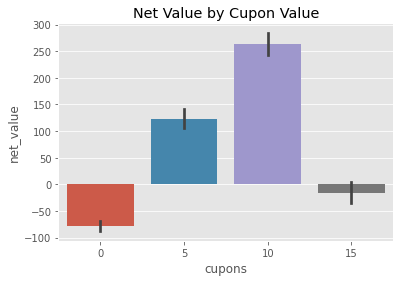

In [17]:
sns.barplot(data=customer_features, x="cupons", y="net_value")
plt.title("Net Value by Cupon Value");

In [18]:
customer_features.groupby("cupons").count()

,customer_id,region,income,age,net_value
cupons,,,,,
0,458,458,458,458,458
5,4749,4749,4749,4749,4749
10,4154,4154,4154,4154,4154
15,639,639,639,639,639


In [19]:
train, test = train_test_split(customer_features, test_size=0.3, random_state=13)
train.shape, test.shape

((7000, 6), (3000, 6))

In [20]:
def model_bands(train_set, features, target, model_params, n_bands, seed=1):
    
    np.random.seed(seed)
    
    reg = ensemble.GradientBoostingRegressor(**model_params)
    reg.fit(train_set[features], train_set[target])
    
    bands = pd.qcut(reg.predict(train_set[features]), q=n_bands, retbins=True)[1]
    
    def predict_bands(test_set):
        predictions = reg.predict(test_set[features])
        pred_bands = np.digitize(predictions, bands) 
        return test_set.assign(predictions=predictions, pred_bands=pred_bands)
    
    return predict_bands

In [21]:
model_params = {'n_estimators': 400,
                'max_depth': 4,
                'min_samples_split': 10,
                'learning_rate': 0.01,
                'loss': 'ls'}

features = ["region", "income", "age"]
target = "net_value"

model = model_bands(train, features, target, model_params, n_bands=10)

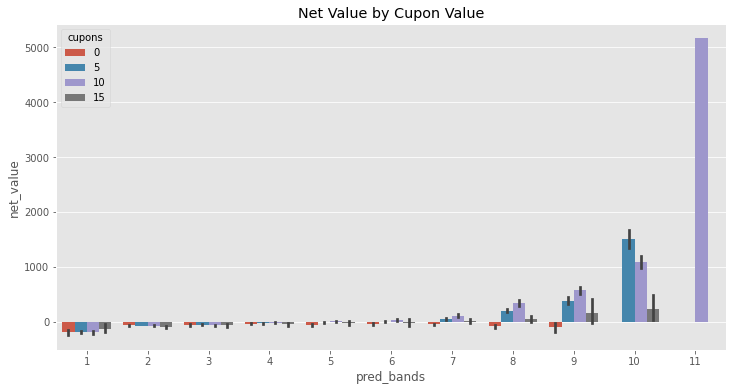

In [22]:
plt.figure(figsize=(12,6))
sns.barplot(data=model(train), x="pred_bands", y="net_value", hue="cupons")
plt.title("Net Value by Cupon Value");